# Task 1 - Sentiment Model

## Data Extraction - code from data_loader_demo.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Exploration
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
import numpy as np
import pandas as pd

import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
import params as p
import functions as f

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, plot_confusion_matrix

import optuna

In [2]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jamesstephenson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jamesstephenson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Settings

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import Data

In [4]:
# The financial_phrasebank dataset is available in four variations. It has no predefined train/validation/test splits.
# Each data point was annotated by 5-8 people, then their annotations were combined. 
# Each variation of the dataset contains examples with different levels of agreement. 
# Let's use the one containing all data points where at least 50% of the annotators agreed on the label.
dataset = load_dataset(
    "financial_phrasebank", 
    'sentences_50agree' # Select variation of the dataset
)

print(f'The dataset is a dictionary with two splits: \n\n{dataset}')

Reusing dataset financial_phrasebank (/Users/jamesstephenson/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/a6d468761d4e0c8ae215c77367e1092bead39deb08fbf4bffd7c0a6991febbf0)
100%|██████████| 1/1 [00:00<00:00, 27.43it/s]

The dataset is a dictionary with two splits: 

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})


In [5]:
# Split test data from training data
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    dataset["train"]['sentence'], 
    dataset["train"]['label'], 
    test_size=0.2, 
    stratify=dataset["train"]['label']  # make sure the same proportion of labels is in the test set and training set
)

In [6]:
# label 0 = negative, 1 = neutral, 2 = positive
print(f'How many instances in the train dataset? \n\n{len(train_sentences)}')
print('')
print(f'What does one instance look like? \n\n{train_sentences[234]}')

How many instances in the train dataset? 

3876

What does one instance look like? 

In October , UPM reported a third-quarter net loss of euro86 million $ 110 million compared with a net profit of euro120 million in 2007 .


It may also be necessary to create a _validation_ set (also called 'development' set or 'devset'). The validation set can be used to compute performance of your model when tuning hyperparameters,  optimising combinations of features, or looking at the errors your model makes before improving it. This allows you to hold out the test set to give a fair evaluation of the model and how well it generalises to new examples. This avoids tuning the model to specifso it gets good performance on the test set examples. 

In [7]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels, test_size=0.25, stratify=train_labels)


In [8]:
print(f'How many instances in the validation dataset? \n\n{len(val_sentences)}\n')
print(f'How many instances in the test dataset? \n\n{len(test_sentences)}')

How many instances in the validation dataset? 

969

How many instances in the test dataset? 

970


## Data Exploration

In [9]:
train = pd.DataFrame({'sentences' : train_sentences, 'labels' : train_labels})

### Very Brief Response Analysis

Should only need to do this for train due to random split. So would expect to see the same structure for test and val

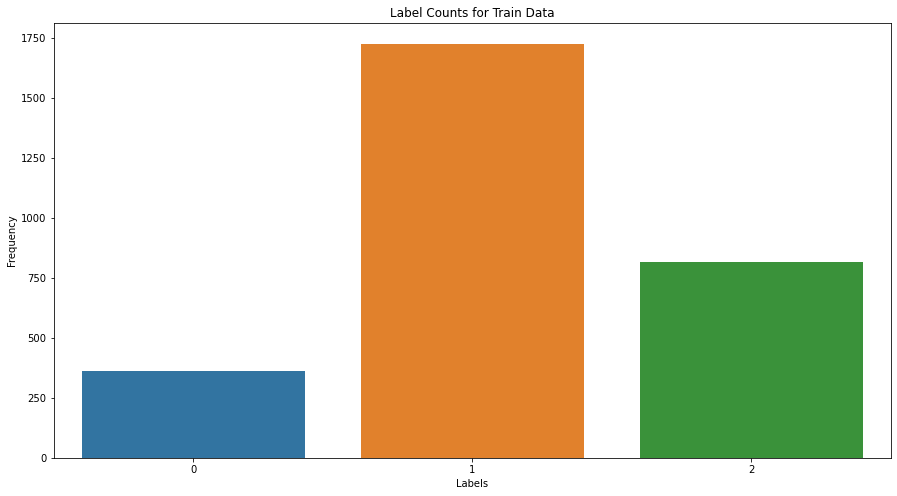

In [10]:
# Make figure and axis
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 8))

# Create plot of label counts
ax = sns.countplot(data = train, x = 'labels').set(title = 'Label Counts for Train Data')

# Edit plot to show correct labels
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.xticks(rotation = 0)

# Show Plot
plt.show()

There is a slight imbalance in labels, but nothing that should be an issue. If we find this is an issue later on, we can perform some over or under sampling.

# Featuring Engineering

### Sentence Processing

In [11]:
# Remove some stopwords to capture negation in n-grams if possible
stop_words = nltk.corpus.stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('but')

# Load up a WordNet Lemmatizer
wnl = nltk.stem.WordNetLemmatizer()

# Define a function to get the position tag for each word - this helps to lemmatize words correctly with context
def get_wordnet_pos(word: str):
        '''Map POS tag to first character lemmatize() accepts
        
        Arguments:
            word (str): word to find wordnet position tag for'''
        
        # Get first letter of pos_tag
        tag = nltk.pos_tag([word])[0][1][0].upper()

        # Translate letter into wordnet position tag
        tag_dict = {
            'J': nltk.corpus.wordnet.ADJ,
            'N': nltk.corpus.wordnet.NOUN,
            'V': nltk.corpus.wordnet.VERB,
            'R': nltk.corpus.wordnet.ADV
            }

        return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def text_preprocess(sentence: str):
    '''Preprocesses the inputted sentence and does the following: sets to lowercase,
    removes unwanted characters, lemmatizes and removes stopwords
    
    Arguments:
        sentence (str): sentence to be processed

    Returns:
        sentence (str): processed sentence'''

    # Set to lower case
    sentence = str(sentence).lower()
    
    # Remove non-letter characters and replace the abbreviation 'mn' for million
    sentence = re.sub(r'[^a-zA-Z]',r' ', sentence)
    sentence = re.sub('mn', 'million', sentence)

    sentence_tokenize = nltk.word_tokenize(sentence)

    # Wordnet lemmatizer with position tagging to give context
    sentence = ' '.join([wnl.lemmatize(word, get_wordnet_pos(word)) for word in sentence_tokenize])
    
    # Removal of Stopwords
    sentence = ' '.join([word for word in sentence_tokenize if word not in stop_words])
    
    return sentence

# Turn the above function into a vectorized function to work on columns for sentences
vect_text_preprocess = np.vectorize(text_preprocess)

In [12]:
# Clean train, test and validation sentences using the vectorised text_processor
clean_train_sentences = vect_text_preprocess(train_sentences)
clean_test_sentences = vect_text_preprocess(test_sentences)
clean_val_sentences = vect_text_preprocess(val_sentences)

#### TF-IDF Vectorizer

We will be using a TF-IDF Vectorizer to vectorize our sentences before modelling. We will be setting the `ngram_range = (1, 1)` so we can also build columns for bi-grams.

In [13]:
# Define TFIDF Vectorizer
tfidf = TfidfVectorizer(min_df = 0.0, max_df = 1.0, ngram_range = (1, 1))

In [14]:
# Fit and transform the clean sentences to the TFIDF Vectorizer for each train, test and validation
X_train = tfidf.fit_transform(clean_train_sentences).toarray()
X_train = pd.DataFrame(X_train, columns = tfidf.get_feature_names_out())

X_test = tfidf.transform(clean_test_sentences).toarray()
X_test = pd.DataFrame(X_test, columns = tfidf.get_feature_names_out())

X_val = tfidf.transform(clean_val_sentences).toarray()
X_val = pd.DataFrame(X_val, columns = tfidf.get_feature_names_out())

## Modelling

We will be using the ROC AUC Score as our evaluation metric since is provides a good balance between True Negative and False Positives in one score. This is preferred to Accuracy due to our imbalance and Precision and Recall since we require a balance of the both to get a good model. Since ROC score uses predicted probabilities as its input, we don't have to tune the threshold.

In [15]:
# Assign train, text and validation labels to the y variable
y_train = train_labels
y_test = test_labels
y_val = val_labels

In [16]:
# Make a dictionary for each train, tes and validation to make fitting and evaluation cleaner.
train_data = {'X' : X_train, 'y' : y_train}
test_data = {'X' : X_test, 'y' : y_test}
val_data = {'X' : X_val, 'y' : y_val}

### Initial Model - Naive Bayes

We have a Naive Bayes Multinomial Classifier since it does not take long to train and tune, but does have a reliable performance. 

In [17]:
nb = MultinomialNB().fit(**train_data)
f.evaluate_model(nb, **test_data, c_report = True, print_metrics = True)

 --- Classification Report --- 
              precision    recall  f1-score   support

           0       0.50      0.01      0.02       121
           1       0.68      0.97      0.80       576
           2       0.62      0.33      0.43       273

    accuracy                           0.67       970
   macro avg       0.60      0.44      0.42       970
weighted avg       0.64      0.67      0.60       970


 --- MACRO METRICS --- 
ROC: 0.80427
ACCURACY: 0.6701
PRECISION: 0.60113
RECALL: 0.43614


### Model Tuning - Naive Bayes

In [18]:
# Define objective we want to optimize
def nb_objective(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):

    # Define paramters we want to adjust
    obj_params = {
        'alpha' : trial.suggest_uniform('alpha', 1e-3, 2),
        'fit_prior' : trial.suggest_categorical('fit_prior', [True, False])
    }

    # Create objective model
    nb_obj = MultinomialNB(**obj_params)
    nb_obj.fit(X_train, y_train)

    # Make predictions from fitted model
    y_pred = nb_obj.predict_proba(X_test)

    # Calculate roc score for model predictions
    roc = roc_auc_score(y_true = y_test, y_score = y_pred, average = 'macro', multi_class='ovr')
    
    # Return roc - metric to be maximized
    return roc

# Create optuna study to maximise objective
nb_study = optuna.create_study(direction='maximize')

# Optimize objective for this study over 200 trails
nb_study.optimize(nb_objective, n_trials = 200, n_jobs = -1)

[I 2022-03-28 22:32:33,231] A new study created in memory with name: no-name-d47c2750-5204-4e57-8b00-a043a66a9cc5
[I 2022-03-28 22:32:34,339] Trial 4 finished with value: 0.8251775453630666 and parameters: {'alpha': 0.18043814996683608, 'fit_prior': False}. Best is trial 4 with value: 0.8251775453630666.
[I 2022-03-28 22:32:34,404] Trial 1 finished with value: 0.8053631318301155 and parameters: {'alpha': 0.9345497517541227, 'fit_prior': True}. Best is trial 4 with value: 0.8251775453630666.
[I 2022-03-28 22:32:34,528] Trial 5 finished with value: 0.8231496409708349 and parameters: {'alpha': 0.12560002219122282, 'fit_prior': False}. Best is trial 4 with value: 0.8251775453630666.
[I 2022-03-28 22:32:34,693] Trial 2 finished with value: 0.8210883865061799 and parameters: {'alpha': 0.5752145491405182, 'fit_prior': False}. Best is trial 4 with value: 0.8251775453630666.
[I 2022-03-28 22:32:34,749] Trial 8 finished with value: 0.8003758059435743 and parameters: {'alpha': 1.8878181503758011,

In [19]:
# Copy best parameters for NB model
nb_tuned_params = nb_study.best_params.copy()

In [20]:
# Create tuned NB model
nb_tuned = MultinomialNB(**nb_tuned_params).fit(**train_data)

#### Overall Evaluation

In [21]:
# Calculate model metrics for each dataset
model_metrics = {
    'Train' : f.evaluate_model(nb_tuned, **train_data),
    'Test' : f.evaluate_model(nb_tuned, **test_data),
    'Validation' : f.evaluate_model(nb_tuned, **val_data)
}

# Display metrics in a dataframe
pd.DataFrame(model_metrics).T

,ROC,Accuracy,Precision,Recall
Train,0.986797,0.920537,0.875362,0.929445
Test,0.825904,0.690722,0.622757,0.639616
Validation,0.843725,0.698658,0.634600,0.659299


This suggests the model is heavily over fit.

### Confusion Matrix

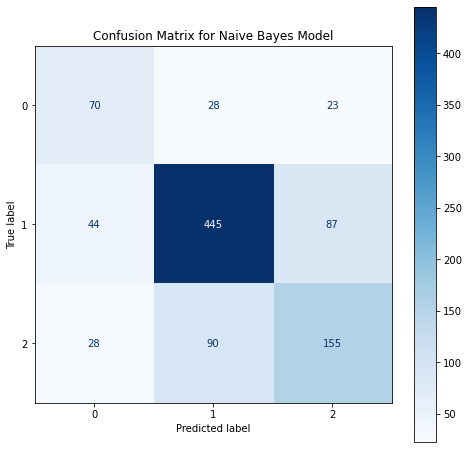

In [22]:
def create_confusion_matrix(model, model_name: str):
    """Calculates and displays a confusion matrix for model

    Args:
        model: model to evaluate
        model_name (str): name of model
    """

    # Create figure and axis to display plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Calculates confusion matrix
    plot_confusion_matrix(model, X_test, y_test, cmap="Blues", ax=ax)

    # Sets title for plot
    plt.title(f"Confusion Matrix for {model_name} Model")

    # Shows plot
    plt.show()

# Calculate confusion matrix for Tuned NB model
create_confusion_matrix(nb_tuned, "Naive Bayes")